# Random Forest Feature Importance Pitfalls

Here we motivate a deeper discussion on explainability by inspecting an example of the pitfalls of a once popular method of explaining random forest (a very popular machine learning model) predictions.

For further reading on this topic, see the following references:

* [Beware Default Random Forest Importances](https://explained.ai/rf-importance/)
* [Stack Overflow post: "Is feature importance in Random Forest useless?"](https://stats.stackexchange.com/questions/450703/is-feature-importance-in-random-forest-useless)
* [Stack Overflow post: "Using Sklearn random forest for feature selection does not give me expected outcome when having categorical data"](https://stackoverflow.com/questions/64237449/using-sklearn-random-forest-for-feature-selection-does-not-give-me-expected-outc)
* [Bias in random forest variable importance measures: Illustrations, sources and a solution](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-25)

Note also that scikit-learn calls out the deficiency in impurity-based feature importances in the documentation for the more reliable [permutation importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# from notebooks.data_generation import generate_challenge_dataset
from data_generation import generate_challenge_dataset

## Train and Test with a Useless Feature Present

Here we train and test with a useless feature present. We introduce "challenge cases" in some data rows where our features which are usually useful are fundamentally inseparable. This forces the model to attempt to make split points on the useless feature, which artificially inflates its importance as assessed by the feature importance algorithm.

Test Accuracy: 0.82


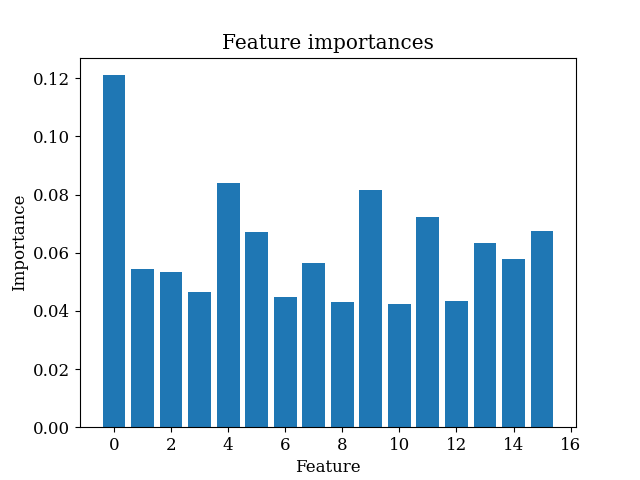

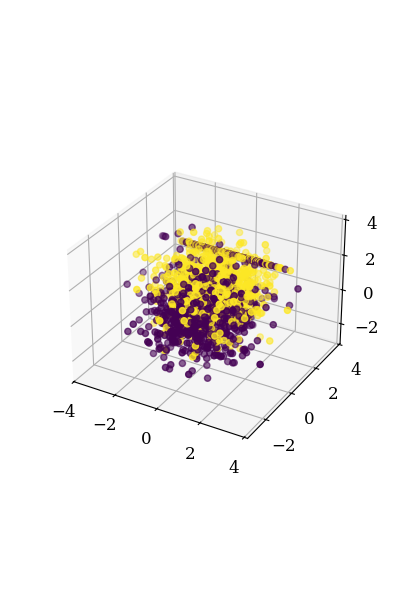

In [ ]:
n_useless_features = 1
x, y = generate_challenge_dataset(n_useless_features)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

# DONT DO THIS - THIS IS THE BAD EXAMPLE
importances = clf.feature_importances_

fig, ax = plt.subplots()
ax.bar(np.arange(len(importances)), importances)
ax.set_title("Feature importances")
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4, 6), subplot_kw={"projection": "3d"})
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y)
plt.show()

## Check Training Data Accuracy to See Why the Algorithm Ranked the Useless Feature High Importance

Here we see high training accuracy with the useless feature inline, indicating the random forest was overfit to it at training time (when feature importance is calculated) despite it not helping at test time.

In [3]:
y_pred_on_train = clf.predict(x_train)
acc = accuracy_score(y_train, y_pred_on_train)
print("Train Accuracy:", acc)

Train Accuracy: 0.98


## Drop the Useless Feature and Train Again

Here we drop the feature that scikit-learn claimed was important and see if there is a significant dip in model accuracy. The model accuracy remains unaffected, indicating that the feature scikit-learn indicated was most "important" was really a useless feature (as expected since it is completely random data with 0 mean and equal variance for both classes).

Note some statistically insignificant deltas in accuracy occur due to the randomization of the data and train/test split.

Test Accuracy: 0.835


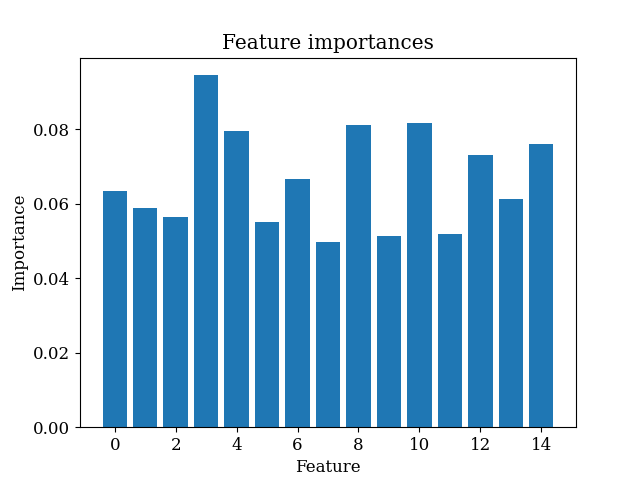

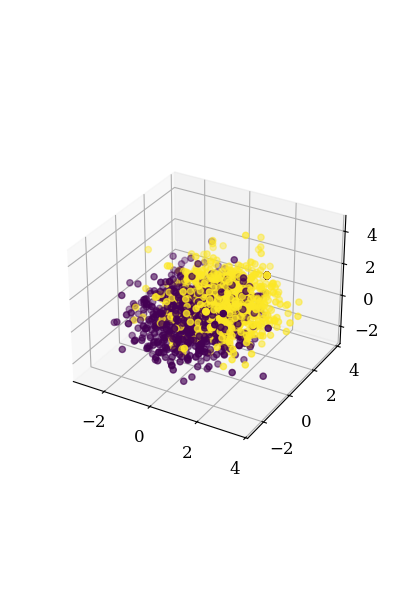

In [ ]:
# Drop the useless feature
x = x[:, n_useless_features:]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

# BAD - DO NOT DO THIS
importances = clf.feature_importances_

fig, ax = plt.subplots()
ax.bar(np.arange(len(importances)), importances)
ax.set_title("Feature importances")
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4, 6), subplot_kw={"projection": "3d"})
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y)
plt.show()

## Assess Effect wrt. Max Depth

Here we see that useless features appear exponentially more important compared to useful features wrt. maximum tree depth, up to a saturation point where the additional tree depth is no longer utilized by the model.

The effect worsens linearly with respect to the number of challenge cases (where features which are normally separable are inseparable and the model must resort to attempting to use the useless features).

In [5]:
def evaluate_random_forest_example(max_depth, n_challenge_rows):
    x, y = generate_challenge_dataset(
        n_useless_features=1, n_challenge_rows=n_challenge_rows
    )

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42
    )

    clf = RandomForestClassifier(
        n_estimators=100, max_depth=max_depth, random_state=42
    )

    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    acc = accuracy_score(y_test, y_pred)

    importances = clf.feature_importances_

    average_useless_importance = np.mean(importances[:n_useless_features])
    average_useful_importance = np.mean(importances[n_useless_features:])

    importance_mismatch_ratio = (
        average_useless_importance / average_useful_importance
    )

    return importance_mismatch_ratio, acc

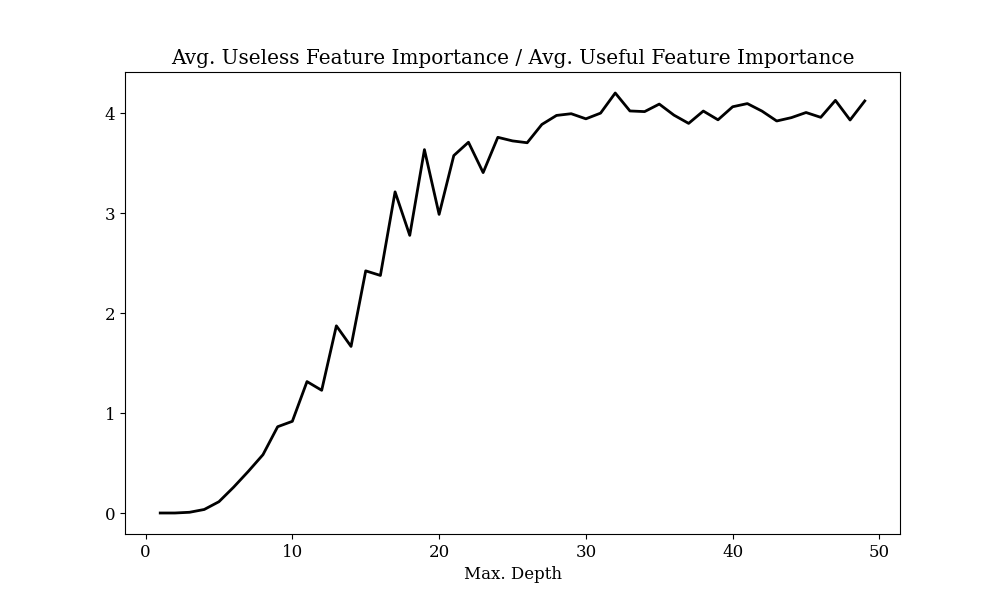

In [6]:
max_tree_depths = np.arange(1, 50)
importance_mismatch_ratios_list = []
acc_list = []

for max_tree_depth in max_tree_depths:
    importance_mismatch_ratio, acc = evaluate_random_forest_example(
        max_tree_depth, n_challenge_rows=400
    )
    importance_mismatch_ratios_list.append(importance_mismatch_ratio)
    acc_list.append(acc)

importance_mismatch_ratios = np.array(importance_mismatch_ratios_list)
acc_values = np.array(acc_list)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(max_tree_depths, importance_mismatch_ratios, linewidth=2, color="k")
ax.set_title(
    "Avg. Useless Feature Importance / Avg. Useful Feature Importance"
)
ax.set_xlabel("Max. Depth")
plt.show()

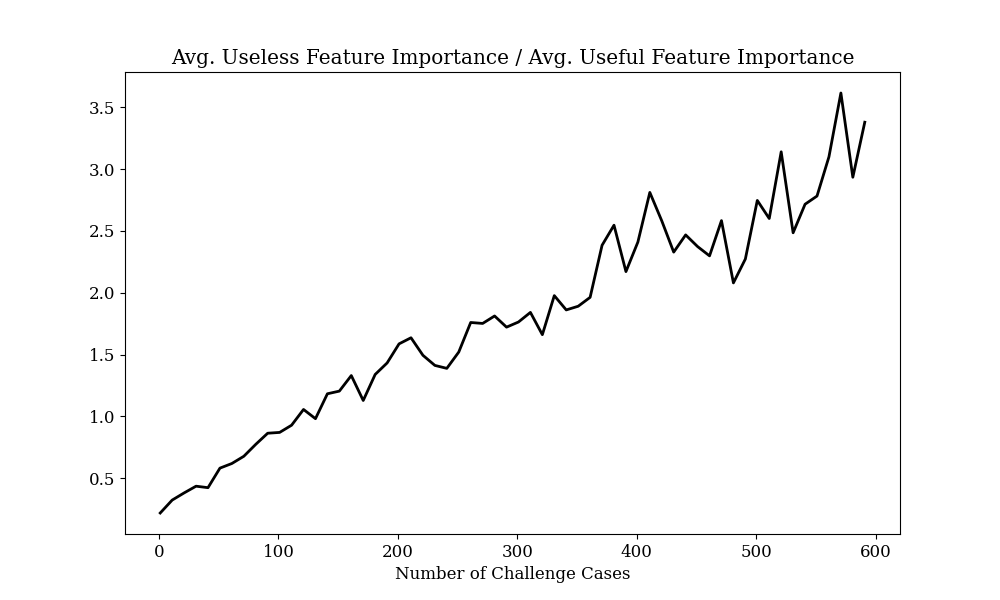

In [7]:
n_challenge_rows_sweep = np.arange(1, 600, 10)
importance_mismatch_ratios_list = []

for n_challenge_rows in n_challenge_rows_sweep:
    importance_mismatch_ratio, _ = evaluate_random_forest_example(
        max_depth=15, n_challenge_rows=n_challenge_rows
    )
    importance_mismatch_ratios_list.append(importance_mismatch_ratio)

importance_mismatch_ratios = np.array(importance_mismatch_ratios_list)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    n_challenge_rows_sweep, importance_mismatch_ratios, linewidth=2, color="k"
)
ax.set_title(
    "Avg. Useless Feature Importance / Avg. Useful Feature Importance"
)
ax.set_xlabel("Number of Challenge Cases")
plt.show()